In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
path_home_team = "data/Train_Data/train_home_team_statistics_df.csv"
path_away_team = "data/Train_Data/train_away_team_statistics_df.csv"

path_target_wdl = "data/Y_train_1rknArQ.csv" 
path_target_goal_diff = "data/Y_train_supp.csv" 

#### Target

In [3]:
data_home_team = pd.read_csv(path_home_team)
data_away_team = pd.read_csv(path_away_team)

target_wdl = pd.read_csv(path_target_wdl)

### 1re approche

In [4]:
for column in data_home_team.columns:
    if 'WON' in column.split('_'):
        print(column)

TEAM_GAME_WON_season_sum
TEAM_GAME_WON_season_average
TEAM_GAME_WON_5_last_match_sum
TEAM_GAME_WON_5_last_match_average


In [5]:
base_columns_of_interest = ['TEAM_GAME_WON_season',
                       'TEAM_GAME_DRAW_season',
                       'TEAM_GAME_LOST_season',
                       'TEAM_GAME_WON_5_last_match',
                       'TEAM_GAME_DRAW_5_last_match',
                       'TEAM_GAME_LOST_5_last_match'] 

columns_of_interest = [col + '_sum' for col in base_columns_of_interest]
columns_of_interest+= ['LEAGUE']

In [6]:
data_home_team_of_interest = data_home_team[columns_of_interest]
data_away_team_of_interest = data_away_team[columns_of_interest]

#### Team points calculataion and comparison for prediction

In [7]:
def compute_team_points(data, win_point=3, draw_point=1, loss_point=0):
    team_points = win_point*data.TEAM_GAME_WON_5_last_match_sum+ draw_point*data.TEAM_GAME_DRAW_5_last_match_sum+loss_point*data.TEAM_GAME_LOST_5_last_match_sum
    return team_points

In [8]:
home_team_points = compute_team_points(data_home_team_of_interest)
away_team_points = compute_team_points(data_away_team_of_interest)

In [9]:
def predict_winning_team(home_team_points, away_team_points, eps=None): 
    
    diff_wins = home_team_points - away_team_points
        
    if eps is None:
        home_wins = np.array(home_team_points>away_team_points)
        away_wins = np.array(home_team_points<away_team_points)
    
    else:
        # relaxation with an epsilon
        home_wins = np.array(diff_wins>eps)
        away_wins = np.array(diff_wins<-eps)
        

    return diff_wins, home_wins*1 - away_wins*1

In [10]:
diff_wins, target_wdl_agg_pred = predict_winning_team(home_team_points, away_team_points)
target_wdl_agg_real = np.array(target_wdl.HOME_WINS - target_wdl.AWAY_WINS)
print((target_wdl_agg_pred==target_wdl_agg_real).sum()/len(target_wdl_agg_real))

0.4278631228155734


In [11]:
for eps in range(1, 6):
    diff_wins, target_wdl_agg_pred = predict_winning_team(home_team_points, away_team_points, eps)
    target_wdl_agg_real = np.array(target_wdl.HOME_WINS - target_wdl.AWAY_WINS)
    print((target_wdl_agg_pred==target_wdl_agg_real).sum()/len(target_wdl_agg_real))

0.42355523043160204
0.42046655287328294
0.4093310574656588
0.40534828903519465
0.40039014874420875


In [20]:
def plot_prediction(colorcode = "pred"):
    if colorcode=="pred":
        plt.scatter(range(len(data_home_team)), diff_wins, c = target_wdl_agg_pred, s=5)
    else:
        plt.scatter(range(len(data_home_team)), diff_wins, c = target_wdl_agg_real, s=5)
        
    title = f"Simple model-winning team=team with most points won on 5 last match-{colorcode}"
    plt.title(title)
    plt.colorbar()
    plt.savefig(fname=f"plots/{title}.png")

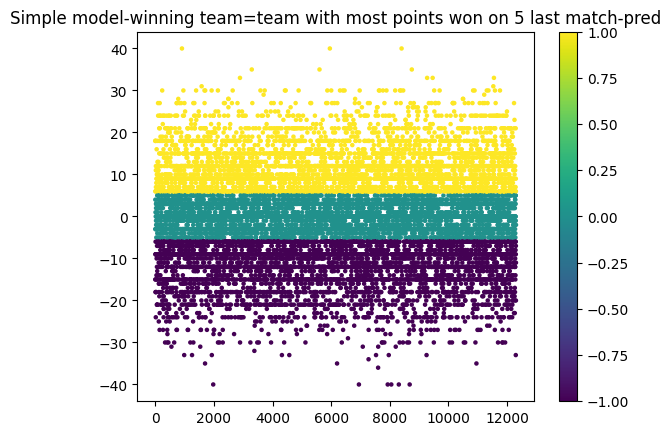

In [21]:
plot_prediction()

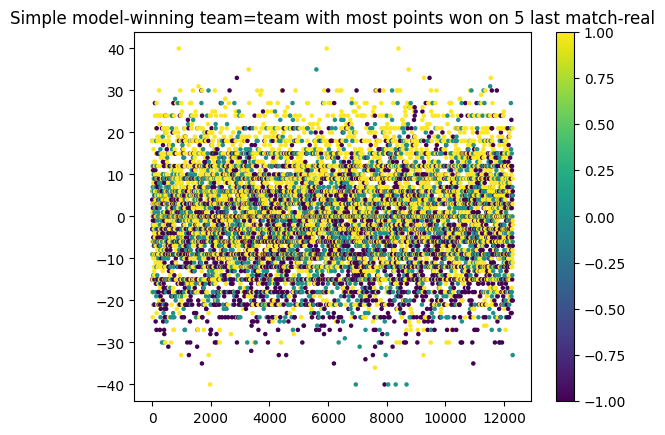

In [22]:
plot_prediction("real")

En observant le plot "plots/Simple model-winning team=team with most points won on 5 last match-real.png" on remarque qu'en général, quand la différence de points est très forte, l'équipe avec le plus de points gagne souvent: 60% d'acc quand on regarde l'accuracy en ne considérant que les matchs où la différence de points sur les 5 derniers matchs est très forte (seuil d'écart = 25). Mais ce cas ne représente que 2% des données de train

Comment traiter les cas où la différence de points reste moins forte

In [23]:
very_high_diff_mask = abs(diff_wins)>=25
print((target_wdl_agg_pred[very_high_diff_mask]==target_wdl_agg_real[very_high_diff_mask]).sum()/len(target_wdl_agg_real[very_high_diff_mask]))


0.6020408163265306


In [27]:
very_high_diff_mask.sum()/len(data_away_team)

0.023896610582784687

#### logistic regression on W-D-L var to predict winning team

In [28]:
data_home_away_team_of_interest = data_home_team_of_interest.iloc[:, :-1] - data_away_team_of_interest.iloc[:, :-1]
data_home_away_team_of_interest['LEAGUE'] = data_home_team_of_interest['LEAGUE']
data_home_away_team_of_interest['TARGET'] = target_wdl.HOME_WINS - target_wdl.AWAY_WINS

In [29]:
data_home_away_team_of_interest

,TEAM_GAME_WON_season_sum,TEAM_GAME_DRAW_season_sum,TEAM_GAME_LOST_season_sum,TEAM_GAME_WON_5_last_match_sum,TEAM_GAME_DRAW_5_last_match_sum,TEAM_GAME_LOST_5_last_match_sum,LEAGUE,TARGET
0,-4.0,-2.0,10.0,-5.0,0.0,5.0,Ligue 1,-1
1,7.0,0.0,-7.0,6.0,0.0,-7.0,Ligue 2,0
2,-1.0,-3.0,3.0,2.0,-2.0,0.0,Serie A,-1
3,5.0,5.0,-6.0,5.0,3.0,-7.0,League One,1
4,-3.0,7.0,0.0,-2.0,3.0,0.0,Premier League,0
...,...,...,...,...,...,...,...,...
12298,0.0,-8.0,5.0,0.0,-7.0,7.0,League One,-1
12299,0.0,3.0,-2.0,2.0,0.0,-2.0,Liga Portugal,-1
12300,-5.0,-3.0,6.0,-5.0,-5.0,10.0,Bundesliga,-1
12301,-3.0,0.0,2.0,-2.0,-5.0,6.0,League One,1


In [30]:
data_home_away_team_of_interest.isnull().sum()

TEAM_GAME_WON_season_sum            8
TEAM_GAME_DRAW_season_sum          15
TEAM_GAME_LOST_season_sum           9
TEAM_GAME_WON_5_last_match_sum      8
TEAM_GAME_DRAW_5_last_match_sum    15
TEAM_GAME_LOST_5_last_match_sum     9
LEAGUE                              0
TARGET                              0
dtype: int64

In [31]:
mask_na = np.array(data_home_away_team_of_interest.isnull().sum(axis=1)>0)
#np.save("mask_nan_team_season_and_five_last_wdl_vars.npy", mask_na)

In [32]:
data_home_away_team_of_interest.dropna(axis=0, inplace=True)
print(data_home_away_team_of_interest.shape)

(12277, 8)


In [33]:
data_home_away_team_of_interest.isnull().sum()

TEAM_GAME_WON_season_sum           0
TEAM_GAME_DRAW_season_sum          0
TEAM_GAME_LOST_season_sum          0
TEAM_GAME_WON_5_last_match_sum     0
TEAM_GAME_DRAW_5_last_match_sum    0
TEAM_GAME_LOST_5_last_match_sum    0
LEAGUE                             0
TARGET                             0
dtype: int64

Train test split

In [34]:
np.unique(data_home_away_team_of_interest.iloc[:, 6], return_counts=True)

(array(['Bundesliga', 'Eredivisie', 'J-League', 'La Liga', 'League One',
        'League Two', 'Liga Portugal', 'Ligue 1', 'Ligue 2',
        'Premier League', 'Pro League', 'Serie A', 'Superliga'],
       dtype=object),
 array([ 774,  673,  780,  972,  843, 1373,  771,  848,  883,  628,  647,
        1964, 1121]))

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(data_home_away_team_of_interest.iloc[:, :6],
                                                    data_home_away_team_of_interest.iloc[:, 7],
                                                    stratify=data_home_away_team_of_interest.iloc[:, 6],
                                                    )

In [36]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9207, 6)
(3070, 6)
(9207,)
(3070,)


In [37]:
model_wdl = LogisticRegression(fit_intercept=True)
model_wdl.fit(X_train, Y_train)

LogisticRegression()

In [38]:
print(model_wdl.intercept_)
print(model_wdl.coef_)

[-0.10489411 -0.18116642  0.28606053]
[[-0.02821409  0.01523901  0.06263698 -0.01610378 -0.00766039 -0.01203718]
 [-0.00696411  0.00141002 -0.00762355 -0.00885168 -0.0069859   0.00037772]
 [ 0.0351782  -0.01664902 -0.05501343  0.02495547  0.01464629  0.01165947]]


In [39]:
Y_train_pred = model_wdl.predict(X_train)
Y_test_pred = model_wdl.predict(X_test)

In [40]:
print((Y_train_pred==Y_train).sum()/len(Y_train))
print((Y_test_pred==Y_test).sum()/len(Y_test))

0.48202454654067556
0.4719869706840391


In [41]:
def softmax(scores):
    exp_scores = np.exp(scores)
    if scores.shape[0]>1:
        probs = exp_scores / np.sum(exp_scores, axis=0)
    else:
        probs = exp_scores/(1+exp_scores)
    return probs

In [43]:
def predict_proba(model, X, mode = None):
    
    if mode is None:
        logits = model.coef_.dot(X.T) + model.intercept_.reshape((3, 1))
        Y_probs = softmax(logits).T
    
    elif mode == 'bin':
        logits = model.coef_.dot(X.T) + model.intercept_
        Y_probs = softmax(logits).T

    else:
        raise NotImplementedError        

    return Y_probs

In [44]:
Y_probs = predict_proba(model_wdl, X_test)
Y_probs

array([[0.08863427, 0.18236803, 0.72899769],
       [0.17855175, 0.21792312, 0.60352513],
       [0.44252205, 0.27069565, 0.2867823 ],
       ...,
       [0.37939804, 0.26827771, 0.35232425],
       [0.45591382, 0.28571664, 0.25836955],
       [0.36725227, 0.26914631, 0.36360143]])

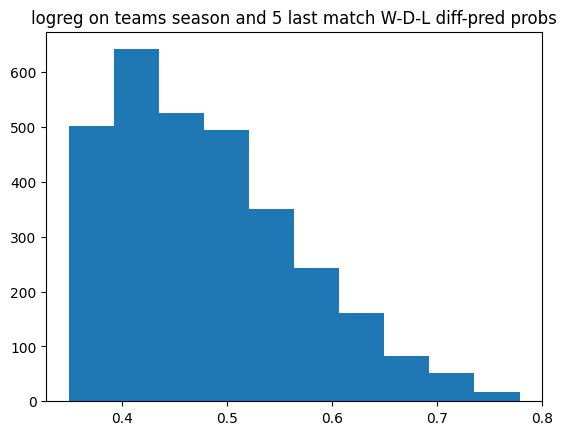

In [45]:
plt.hist(np.max(Y_probs, axis=1))
title = "logreg on teams season and 5 last match W-D-L diff-pred probs"
plt.title(title)
plt.savefig(f"plots/{title}.png")

In [47]:
good_pred_prob_threshold = 0.55 # ROC to determine the good threshold
pred_probs = np.max(Y_probs, axis=1)

good_pred_probs_mask = pred_probs>=good_pred_prob_threshold
print((good_pred_probs_mask).sum()/Y_probs.shape[0])

preds_wdl = np.argmax(Y_probs, axis=1)
preds_wdl[preds_wdl==0] = -1
preds_wdl[preds_wdl==1] = 0
preds_wdl[preds_wdl==2] = 1

print((preds_wdl[good_pred_probs_mask]==Y_test[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum())

0.21661237785016288
0.5939849624060151


La régression logistique uniquement sur les données de W/D/L (season+5 last matchs) est sûr à plus de 55% de sa prédiction pour seulement 20% des données. Sur ces 20% de données, la précision de la prédiction du résultat passe de 48% à 61%.

Etude de la précision en fonction du seuil de proba

In [48]:
def threshold_cond_acc(Y_probs, Y_true, good_pred_prob_threshold, mode=None, cats = None):

    if mode is None:
        pred_probs = np.max(Y_probs, axis=1)

        preds = np.argmax(Y_probs, axis=1)
        preds[preds==0] = -1
        preds[preds==1] = 0
        preds[preds==2] = 1

    elif mode == 'bin':
        pred_probs = Y_probs.copy()

        preds = 1*(pred_probs>=0.5)
        if cats == 'wl' or cats=='ld':
            preds[preds==0] = -1
    else:
        raise NotImplementedError

    good_pred_probs_mask = pred_probs>=good_pred_prob_threshold
    data_proportion = good_pred_probs_mask.sum()/Y_probs.shape[0]
    cond_acc = (preds[good_pred_probs_mask]==Y_true[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum()

    return data_proportion, cond_acc

In [49]:
good_pred_prob_thresholds = np.linspace(0.45, 0.95, 50)
data_proportions = []
cond_accs = []

for good_pred_prob_threshold in good_pred_prob_thresholds:
    data_proportion, cond_acc = threshold_cond_acc(Y_probs, Y_test, good_pred_prob_threshold)
    data_proportions.append(data_proportion)
    cond_accs.append(cond_acc)

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_94408/4235701267.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cond_acc = (preds[good_pred_probs_mask]==Y_true[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum()


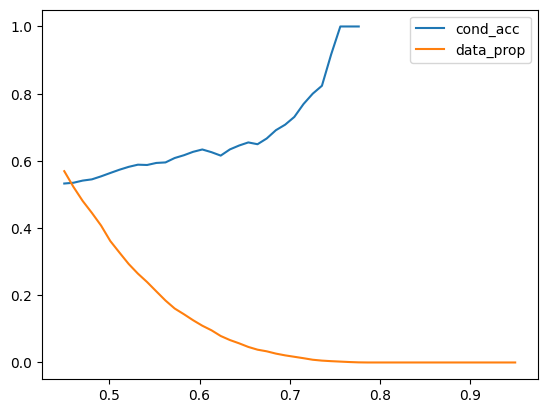

In [51]:
plt.figure()
plt.plot(good_pred_prob_thresholds, cond_accs, label = 'cond_acc')
plt.plot(good_pred_prob_thresholds, data_proportions, label = 'data_prop')
plt.legend()
plt.show()

Le plot ci-dessus montre quand le seuil de bonne prédiction augmente, la proportion de données diminue et la précision de prédiction augmente. Avec un seuil à 0.6, la proportion de données est autour des 10% et la précision entre 0.65 et 0.7. Cela reste très peu en terme de quantité de données prise en compte, mais aussi en terme de précision. Cependant, on a au moins une garantie d'avoir 65% de précision sur 10% des données, quand on descend le seuil à 0.55, on récupère 20% des données mais on perd 5% en précision.

On aimerait d'abord extraire une partie des données sur lesquelles on a un certaine précision minimale (plutôt élevée), et sur le reste des données, on refait une reglog sur les deux première classes les plus probables. Cependant, au vu des précisions plutôt faibles qu'on obtient même pour une toute petite proprotion des données (65% à 10%), on va directement refaire la reglog sur le top2 des classes, dont on sait avoir une précision de 75%.

#### Analyse du score en top2

In [52]:
is_good_pred_top2 = []
for idx, y in enumerate(Y_test):
    if y==-1:
        y=0
    elif y==0:
        y=1
    else:
        y=2

    if y in np.argsort(Y_probs[idx])[1:]:
        is_good_pred_top2.append(True)
    else:
        is_good_pred_top2.append(False)

is_good_pred_top2 = np.array(is_good_pred_top2)

In [53]:
is_good_pred_top1 = preds_wdl==Y_test
Y_probs_sort = np.sort(Y_probs[is_good_pred_top1], axis=1)

In [54]:
ecart = Y_probs_sort[:, 1:] - Y_probs_sort[:, :2]

(array([228., 225., 243., 209., 202., 179., 115.,  38.,   9.,   1.]),
 array([7.74931618e-05, 1.33632336e-02, 2.66489740e-02, 3.99347145e-02,
        5.32204549e-02, 6.65061954e-02, 7.97919358e-02, 9.30776762e-02,
        1.06363417e-01, 1.19649157e-01, 1.32934898e-01]),
 <BarContainer object of 10 artists>)

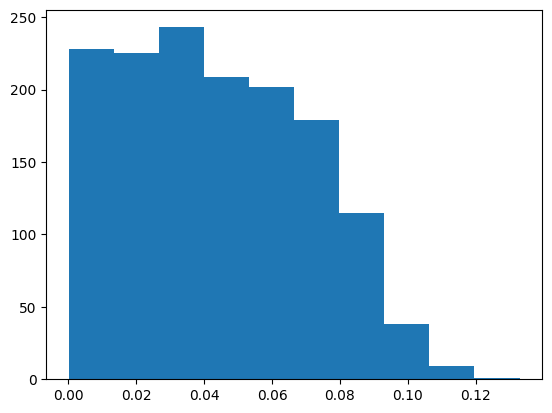

In [55]:
plt.hist(ecart[:, 0])

(array([183., 178., 244., 261., 236., 141., 106.,  54.,  34.,  12.]),
 array([5.32011054e-04, 6.28132159e-02, 1.25094421e-01, 1.87375626e-01,
        2.49656831e-01, 3.11938035e-01, 3.74219240e-01, 4.36500445e-01,
        4.98781650e-01, 5.61062855e-01, 6.23344060e-01]),
 <BarContainer object of 10 artists>)

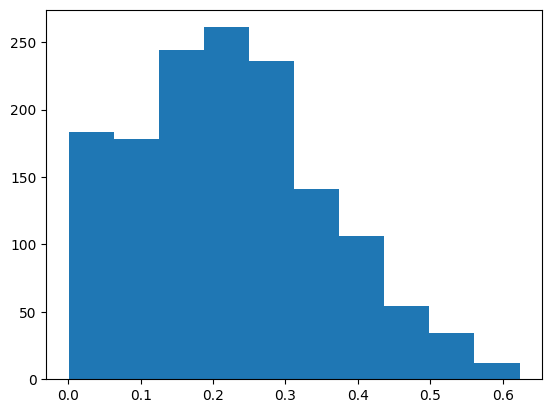

In [56]:
plt.hist(ecart[:, 1])

La précision de prédiction passe de 0.49 en top1 à à 0.75 en top2. En observant les écarts, on se rend compte que la régression logistique est en générale très sûr de sa prédiction, l'écart moyen de proba de prédiction entre les deux premières classes les plus probables est 5 fois plus élevé que celui entre la 2è et la 3è classe la plus probable. La question now est: à quel point elle est sûr d'elle quand elle se trompe ?

In [57]:
Y_probs_sort_bad_pred = np.sort(Y_probs[~is_good_pred_top1], axis=1)
ecart_bad_pred = Y_probs_sort_bad_pred[:, 1:] - Y_probs_sort_bad_pred[:, :2]

(array([272., 277., 243., 253., 221., 191., 121.,  34.,   7.,   2.]),
 array([9.10526968e-06, 1.33016845e-02, 2.65942637e-02, 3.98868430e-02,
        5.31794222e-02, 6.64720014e-02, 7.97645807e-02, 9.30571599e-02,
        1.06349739e-01, 1.19642318e-01, 1.32934898e-01]),
 <BarContainer object of 10 artists>)

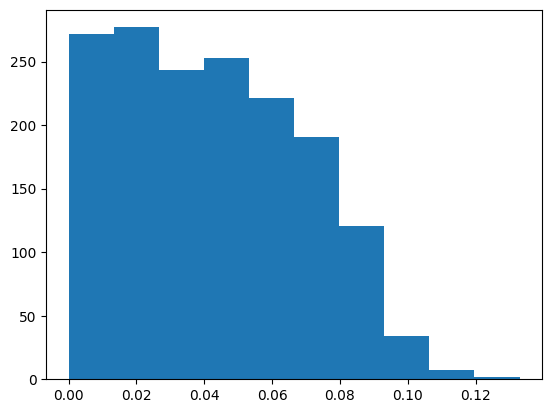

In [58]:
plt.hist(ecart_bad_pred[:, 0])

(array([284., 306., 256., 271., 217., 131.,  77.,  42.,  27.,  10.]),
 array([6.25147096e-05, 5.84741341e-02, 1.16885754e-01, 1.75297373e-01,
        2.33708992e-01, 2.92120612e-01, 3.50532231e-01, 4.08943851e-01,
        4.67355470e-01, 5.25767089e-01, 5.84178709e-01]),
 <BarContainer object of 10 artists>)

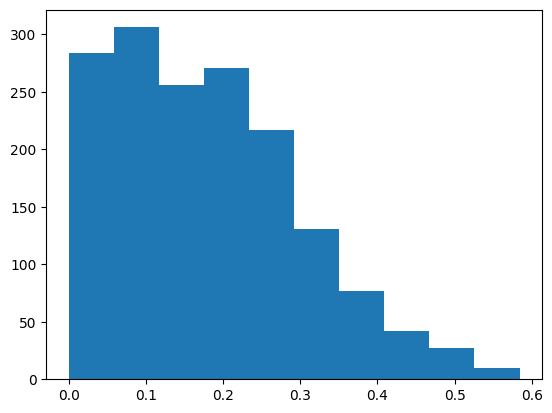

In [59]:
plt.hist(ecart_bad_pred[:, 1])

En observant l'histogramme, on se rend compte que la reglog a les mêmes distributions de probas de prédiction quand elle se trompe que quand elle ne se trompe pas. Seuiller sur ses probas de prédiction permet de filter les mauvaises prédictions mais ces probas sont loin d'être 100% pour détecter les mauvaises prédictions.

#### Etude de prédictions binaires

Au vu du fait que le score en top2 est très élevé, on va créer trois modèles binaires pour les classes deux à deux et un modèle tertiaire.
Méthode de prédiction: on utilise le modèle tertiaire, si la proba de la meilleure classe est supérieure au seuil, on accepte la prédiction. Sinon on recupère le top2 et on utilise le modèle binaire pour départager. Si le modèle binaire a une proba supérieure au seuil, on accepte sa prédiction, sinon donnée paria.

In [60]:
def bin_model(idx2drop, Y_test, X_test, Y_train, X_train, model_type = 'reglog'):
    mask_te = Y_test!=idx2drop
    Y_te = np.array(Y_test)[mask_te]
    X_te = np.array(X_test)[mask_te]

    mask_tr = Y_train!=idx2drop
    Y_tr = np.array(Y_train)[mask_tr]
    X_tr = np.array(X_train)[mask_tr]

    print(np.unique(Y_te, return_counts=True))
    print(np.unique(Y_tr, return_counts=True))

    if model_type=='reglog':
        model = LogisticRegression()
    elif model_type=='svm':
        model = SVC(probability=True)
    elif model_type=='nb':
        model = GaussianNB()
    else:
        raise NotImplementedError
    
    model.fit(X_tr, Y_tr)

    print(model.score(X_te, Y_te))
    print(model.score(X_tr, Y_tr))
    
    return model, Y_te, X_te, Y_tr, X_tr

In [61]:
model_wl, Y_te_wl, X_te_wl, Y_tr_wl, X_tr_wl = bin_model(0, Y_test, X_test, Y_train, X_train, 'nb')

(array([-1,  1]), array([ 953, 1344]))
(array([-1,  1]), array([2803, 3995]))
0.6225511536787114
0.6400411885848779


(array([ 92.,  95., 101., 110., 123., 120., 146., 174., 224., 245.]),
 array([0.00132615, 0.10090008, 0.20047402, 0.30004795, 0.39962189,
        0.49919582, 0.59876976, 0.69834369, 0.79791762, 0.89749156,
        0.99706549]),
 <BarContainer object of 10 artists>)

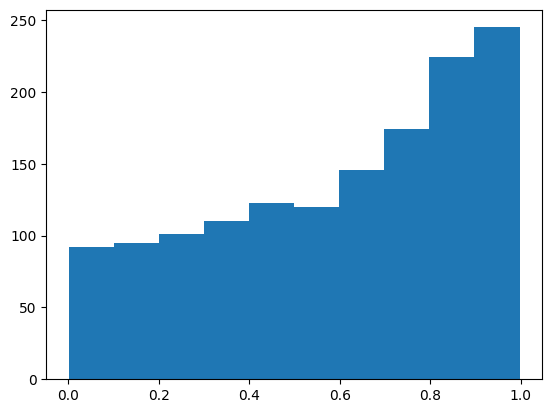

In [62]:
mask = model_wl.predict(X_te_wl)==Y_te_wl
xx = model_wl.predict_proba(X_te_wl[mask])
plt.hist(np.sort(xx, axis=1)[:, 1]- np.sort(xx, axis=1)[:, 0])

Cas intéressants:

Pour la GaussianNB, les écarts de probas ne sont pas significativement plus faibles en cas de mauvaise prédiction, mais sont significativement plus forts en cas de bonne prédiction

Pour la reglog, les écarts de probas sont significativement plus faibles en cas de mauvaise prédiction, mais ne sont pas significativement plus forts en cas de bonne prédiction

In [65]:
model_wd, Y_te_wd, X_te_wd, Y_tr_wd, X_tr_wd = bin_model(-1, Y_test, X_test, Y_train, X_train, 'nb')

(array([0, 1]), array([ 773, 1344]))
(array([0, 1]), array([2409, 3995]))
0.5791213982050071
0.6075890068707058


(array([151., 135., 126., 150., 112.,  75.,  60.,  34.,  31.,  17.]),
 array([0.00101568, 0.09644502, 0.19187437, 0.28730371, 0.38273305,
        0.4781624 , 0.57359174, 0.66902108, 0.76445043, 0.85987977,
        0.95530911]),
 <BarContainer object of 10 artists>)

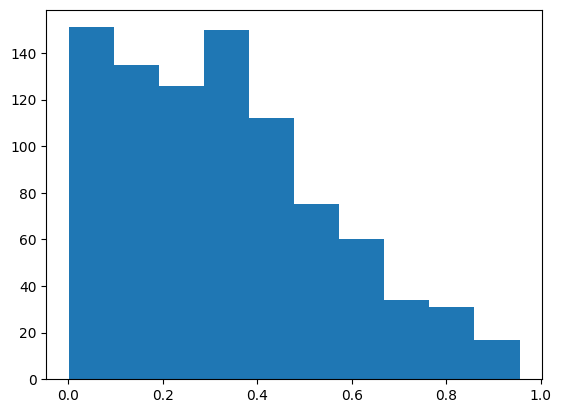

In [66]:
mask = model_wd.predict(X_te_wd)!=Y_te_wd
xx = model_wd.predict_proba(X_te_wd[mask])
plt.hist(np.sort(xx, axis=1)[:, 1]- np.sort(xx, axis=1)[:, 0])

Cas intéressant: Pour la gaussianNB, les écarts sont significativement plus faibles en cas de mauvaises prédictions

In [67]:
model_ld, Y_te_ld, X_te_ld, Y_tr_ld, X_tr_ld = bin_model(1, Y_test, X_test, Y_train, X_train, 'nb')

(array([-1,  0]), array([953, 773]))
(array([-1,  0]), array([2803, 2409]))
0.5735805330243338
0.5598618572524943


(array([116., 130., 123., 107.,  92.,  68.,  40.,  37.,  16.,   7.]),
 array([6.69058982e-04, 8.78788254e-02, 1.75088592e-01, 2.62298358e-01,
        3.49508125e-01, 4.36717891e-01, 5.23927657e-01, 6.11137424e-01,
        6.98347190e-01, 7.85556957e-01, 8.72766723e-01]),
 <BarContainer object of 10 artists>)

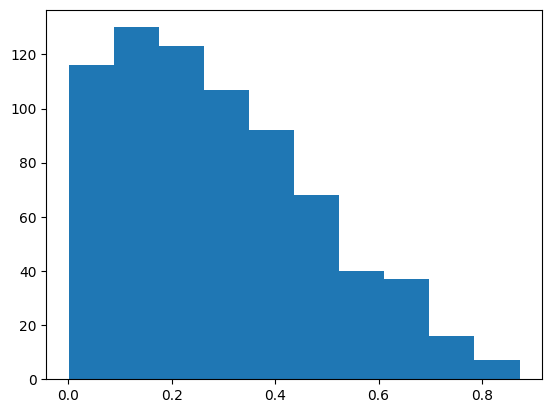

In [68]:
mask = model_ld.predict(X_te_ld)!=Y_te_ld
xx = model_ld.predict_proba(X_te_ld[mask])
plt.hist(np.sort(xx, axis=1)[:, 1]- np.sort(xx, axis=1)[:, 0])

In [69]:
Y_probs_wdl = predict_proba(model_wdl, X_test)
#Y_probs_wl = predict_proba(model_wl, X_te_wl, mode='bin')
Y_probs_wl = np.max(model_wl.predict_proba(X_te_wl), axis=1).reshape(-1, 1)
#Y_probs_wd = predict_proba(model_wd, X_te_wd, mode='bin')
Y_probs_wd = np.max(model_wd.predict_proba(X_te_wd), axis=1).reshape(-1, 1)
#Y_probs_ld = predict_proba(model_ld, X_te_ld, mode='bin')
Y_probs_ld = np.max(model_ld.predict_proba(X_te_ld), axis=1).reshape(-1, 1)

In [70]:
Y_probs_wd.shape

(2117, 1)

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_94408/4235701267.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cond_acc = (preds[good_pred_probs_mask]==Y_true[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum()


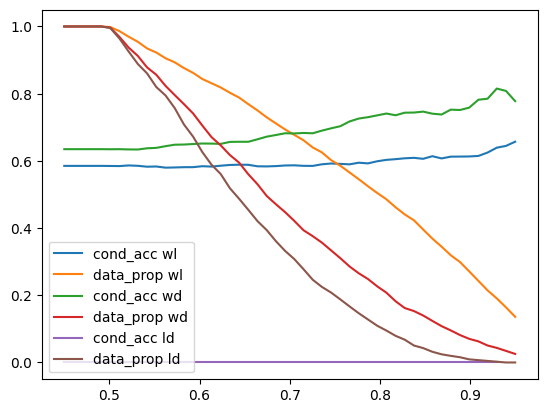

In [71]:
good_pred_prob_thresholds = np.linspace(0.45, 0.95, 50)
data_proportions_wl, data_proportions_wd, data_proportions_ld = [], [], []
cond_accs_wl, cond_accs_wd, cond_accs_ld = [], [], []

for good_pred_prob_threshold in good_pred_prob_thresholds:
    data_proportion_wl, cond_acc_wl = threshold_cond_acc(Y_probs_wl[:, 0], Y_te_wl, good_pred_prob_threshold, mode='bin', cats='wl')
    data_proportions_wl.append(data_proportion_wl)
    cond_accs_wl.append(cond_acc_wl)
    
    data_proportion_wd, cond_acc_wd = threshold_cond_acc(Y_probs_wd[:, 0], Y_te_wd, good_pred_prob_threshold, mode='bin')
    data_proportions_wd.append(data_proportion_wd)
    cond_accs_wd.append(cond_acc_wd)
    
    data_proportion_ld, cond_acc_ld = threshold_cond_acc(Y_probs_ld[:, 0], Y_te_ld, good_pred_prob_threshold, mode='bin', cats='ld')
    data_proportions_ld.append(data_proportion_ld)
    cond_accs_ld.append(cond_acc_ld)

plt.figure()
plt.plot(good_pred_prob_thresholds, cond_accs_wl, label = 'cond_acc wl')
plt.plot(good_pred_prob_thresholds, data_proportions_wl, label = 'data_prop wl')

plt.plot(good_pred_prob_thresholds, cond_accs_wd, label = 'cond_acc wd')
plt.plot(good_pred_prob_thresholds, data_proportions_wd, label = 'data_prop wd')

plt.plot(good_pred_prob_thresholds, cond_accs_ld, label = 'cond_acc ld')
plt.plot(good_pred_prob_thresholds, data_proportions_ld, label = 'data_prop ld')

plt.legend()
plt.show()

In [72]:
idx2label = {-1:0, 0:1, 1:2}
Y_pred = 100*np.ones((Y_test.shape[0]))

wdl_threshold = 0.55
mask_wdl_bad_pred = np.max(Y_probs_wdl, axis=1) < wdl_threshold
Y_pred[~mask_wdl_bad_pred] = model_wdl.predict(X_test)[~mask_wdl_bad_pred]

for idx, val in enumerate(mask_wdl_bad_pred):
    if val:
        probs = Y_probs_wdl[idx]
        top2 = np.argsort(probs)[1:]
        
        if idx2label[-1] in top2 and idx2label[0] in top2:
            Y_pred[idx] = model_ld.predict(np.array(X_test)[idx].reshape(1, -1))
        
        elif idx2label[1] in top2 and idx2label[-1] in top2:
            Y_pred[idx] = model_wl.predict(np.array(X_test)[idx].reshape(1, -1))

        else:
            Y_pred[idx] = model_wd.predict(np.array(X_test)[idx].reshape(1, -1))

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_94408/1080382041.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_pred[idx] = model_wl.predict(np.array(X_test)[idx].reshape(1, -1))
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_94408/1080382041.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_pred[idx] = model_wd.predict(np.array(X_test)[idx].reshape(1, -1))
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_94408/1080382041.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

In [73]:
print((Y_pred == Y_test).sum()/len(Y_test))

0.4671009771986971


L'idée d'entraîner des modèles binaires rajoute de la complexité mais n'a presque pas d'effets sur la prédiction. Même en essayant de seuiller les modèles binaires pour gagner en précision et en quantité de données prise en compte, cela ne marche pas. La courbe des data_prop&cond_acc/seuil le confirme. La reglog donne des résultats correct

SVC

In [74]:
model_svm = SVC(probability=True)
model_svm.fit(X_train, Y_train)

SVC(probability=True)

In [75]:
Y_train_pred = model_svm.predict(X_train)
Y_test_pred = model_svm.predict(X_test)
print((Y_train_pred==Y_train).sum()/len(Y_train))
print((Y_test_pred==Y_test).sum()/len(Y_test))

0.48788964917997174
0.4755700325732899


In [76]:
probs = model_svm.predict_proba(X_test)
probs.shape

(3070, 3)

In [77]:
good_pred_prob_threshold = 0.5
pred_probs = np.max(probs, axis=1)
good_pred_probs_mask = pred_probs>=good_pred_prob_threshold

print(good_pred_probs_mask.sum()/probs.shape[0])

preds_wdl = np.argmax(probs, axis=1)
preds_wdl[preds_wdl==0] = -1
preds_wdl[preds_wdl==1] = 0
preds_wdl[preds_wdl==2] = 1

print((preds_wdl[good_pred_probs_mask]==Y_test[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum())

0.43713355048859937
0.5380029806259314


In [78]:
bad_pred_probs_mask = pred_probs<good_pred_prob_threshold

In [90]:
np.save("results/logreg_on_wdl_vars_bad_pred_probs_mask_0_55_threshlod.npy", bad_pred_probs_mask)

In [125]:
bad_pred_probs_mask = np.load("results/logreg_on_wdl_vars_bad_pred_probs_mask_0_55_threshlod.npy")
mask_na = np.load("results/mask_nan_team_season_and_five_last_wdl_vars.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'results/mask_nan_team_season_and_five_last_wdl_vars.npy'

#### Error analysis

In [84]:
for column in data_home_team.columns:
    if "5_last_match" in column:
        print(column)

TEAM_SHOTS_TOTAL_5_last_match_sum
TEAM_SHOTS_INSIDEBOX_5_last_match_sum
TEAM_SHOTS_OFF_TARGET_5_last_match_sum
TEAM_SHOTS_ON_TARGET_5_last_match_sum
TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum
TEAM_PASSES_5_last_match_sum
TEAM_SUCCESSFUL_PASSES_5_last_match_sum
TEAM_SAVES_5_last_match_sum
TEAM_CORNERS_5_last_match_sum
TEAM_FOULS_5_last_match_sum
TEAM_YELLOWCARDS_5_last_match_sum
TEAM_REDCARDS_5_last_match_sum
TEAM_OFFSIDES_5_last_match_sum
TEAM_ATTACKS_5_last_match_sum
TEAM_PENALTIES_5_last_match_sum
TEAM_SUBSTITUTIONS_5_last_match_sum
TEAM_BALL_SAFE_5_last_match_sum
TEAM_DANGEROUS_ATTACKS_5_last_match_sum
TEAM_INJURIES_5_last_match_sum
TEAM_GOALS_5_last_match_sum
TEAM_GAME_WON_5_last_match_sum
TEAM_GAME_DRAW_5_last_match_sum
TEAM_GAME_LOST_5_last_match_sum
TEAM_SHOTS_TOTAL_5_last_match_average
TEAM_SHOTS_INSIDEBOX_5_last_match_average
TEAM_SHOTS_OFF_TARGET_5_last_match_average
TEAM_SHOTS_ON_TARGET_5_last_match_average
TEAM_SHOTS_OUTSIDEBOX_5_last_match_average
TEAM_PASSES_5_last_match_aver

preparing the rest of the data

In [85]:
"""
TEAM_SHOTS_TOTAL_5_last_match_sum
TEAM_SHOTS_INSIDEBOX_5_last_match_sum
TEAM_SHOTS_ON_TARGET_5_last_match_sum
TEAM_PASSES_5_last_match_sum
TEAM_SUCCESSFUL_PASSES_5_last_match_sum
TEAM_SAVES_5_last_match_sum
TEAM_REDCARDS_5_last_match_sum
TEAM_ATTACKS_5_last_match_sum
TEAM_PENALTIES_5_last_match_sum
TEAM_BALL_SAFE_5_last_match_sum
TEAM_DANGEROUS_ATTACKS_5_last_match_sum
TEAM_INJURIES_5_last_match_sum
TEAM_GOALS_5_last_match_sum

TEAM_SHOTS_TOTAL_5_last_match_average
TEAM_SHOTS_INSIDEBOX_5_last_match_average
TEAM_SHOTS_ON_TARGET_5_last_match_average
TEAM_PASSES_5_last_match_average
TEAM_SUCCESSFUL_PASSES_5_last_match_average
TEAM_SAVES_5_last_match_average
TEAM_REDCARDS_5_last_match_average
TEAM_ATTACKS_5_last_match_average
TEAM_PENALTIES_5_last_match_average
TEAM_BALL_SAFE_5_last_match_average
TEAM_DANGEROUS_ATTACKS_5_last_match_average
TEAM_INJURIES_5_last_match_average
TEAM_GOALS_5_last_match_average

TEAM_SHOTS_TOTAL_5_last_match_std
TEAM_SHOTS_INSIDEBOX_5_last_match_std
TEAM_SHOTS_ON_TARGET_5_last_match_std
TEAM_PASSES_5_last_match_std
TEAM_SUCCESSFUL_PASSES_5_last_match_std
TEAM_SAVES_5_last_match_std
TEAM_REDCARDS_5_last_match_std
TEAM_ATTACKS_5_last_match_std
TEAM_PENALTIES_5_last_match_std
TEAM_BALL_SAFE_5_last_match_std
TEAM_DANGEROUS_ATTACKS_5_last_match_std
TEAM_INJURIES_5_last_match_std
TEAM_GOALS_5_last_match_std"""

columns_of_interest = ["TEAM_SHOTS_TOTAL_5_last_match_average",
                        "TEAM_SHOTS_INSIDEBOX_5_last_match_average",
                        "TEAM_SHOTS_ON_TARGET_5_last_match_average",
                        "TEAM_PASSES_5_last_match_average",
                        "TEAM_SUCCESSFUL_PASSES_5_last_match_average",
                        "TEAM_SAVES_5_last_match_average",
                        "TEAM_REDCARDS_5_last_match_average",
                        "TEAM_ATTACKS_5_last_match_average",
                        "TEAM_PENALTIES_5_last_match_average",
                        "TEAM_BALL_SAFE_5_last_match_average",
                        "TEAM_DANGEROUS_ATTACKS_5_last_match_average",
                        "TEAM_INJURIES_5_last_match_average",
                        "TEAM_GOALS_5_last_match_average",
                        "TEAM_SHOTS_TOTAL_5_last_match_std",
                        "TEAM_SHOTS_INSIDEBOX_5_last_match_std",
                        "TEAM_SHOTS_ON_TARGET_5_last_match_std",
                        "TEAM_PASSES_5_last_match_std",
                        "TEAM_SUCCESSFUL_PASSES_5_last_match_std",
                        "TEAM_SAVES_5_last_match_std",
                        "TEAM_REDCARDS_5_last_match_std",
                        "TEAM_ATTACKS_5_last_match_std",
                        "TEAM_PENALTIES_5_last_match_std",
                        "TEAM_BALL_SAFE_5_last_match_std",
                        "TEAM_DANGEROUS_ATTACKS_5_last_match_std",
                        "TEAM_INJURIES_5_last_match_std",
                        "TEAM_GOALS_5_last_match_std"
                        ]

In [92]:
data_home_away_team_of_interest_bad_pred = data_home_team[columns_of_interest][~mask_na][bad_pred_probs_mask] -\
                                           data_away_team[columns_of_interest][~mask_na][bad_pred_probs_mask]

ValueError: Item wrong length 3070 instead of 12277.

In [93]:
data_home_away_team_of_interest_bad_pred['TARGET_wdl'] = data_home_away_team_of_interest[~mask_na][bad_pred_probs_mask]['TARGET'] 
data_home_away_team_of_interest_bad_pred['TARGET_GOAL_DIFF'] = target_goal_diff[~mask_na][bad_pred_probs_mask]['GOAL_DIFF_HOME_AWAY'] 

ValueError: Item wrong length 12303 instead of 12277.

In [94]:
data_home_away_team_of_interest_bad_pred

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

saving and loading

In [95]:
data_home_away_team_of_interest_bad_pred.to_csv("data/add/data_home_away_team_of_interest_rows_bad_pred_reglog_cols_new_vars_of_interest.csv", index=False)

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

In [124]:
data_home_away_team_of_interest_bad_pred = pd.read_csv("data/add/data_home_away_team_of_interest_rows_bad_pred_reglog_cols_new_vars_of_interest.csv")
data_home_away_team_of_interest_bad_pred

FileNotFoundError: [Errno 2] No such file or directory: 'data/add/data_home_away_team_of_interest_rows_bad_pred_reglog_cols_new_vars_of_interest.csv'

In [97]:
for column in data_home_away_team_of_interest_bad_pred.columns:
    if "average" in column:
        plt.figure()
        plt.scatter(range(len(data_home_away_team_of_interest_bad_pred)), data_home_away_team_of_interest_bad_pred[column], c = data_home_away_team_of_interest_bad_pred.TARGET_wdl)
        plt.title(column)
        if 'SHOTS_INSIDEBOX' in column:
            plt.savefig(f'plots/{column}.png')
        plt.show()

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

In [98]:
columns_of_interest = ["TEAM_SHOTS_TOTAL_5_last_match_average",
                        "TEAM_SHOTS_INSIDEBOX_5_last_match_average",
                        "TEAM_SHOTS_ON_TARGET_5_last_match_average",
                        "TEAM_PASSES_5_last_match_average",
                        "TEAM_SUCCESSFUL_PASSES_5_last_match_average",
                        "TEAM_ATTACKS_5_last_match_average",
                        "TEAM_DANGEROUS_ATTACKS_5_last_match_average",
                        "TEAM_GOALS_5_last_match_average"]

x= ['_'.join(column.split('_')[:-1])+'_std' for column in columns_of_interest]

columns_of_interest+=x 
#columns_of_interest+=['LEAGUE']

columns_of_interest

['TEAM_SHOTS_TOTAL_5_last_match_average',
 'TEAM_SHOTS_INSIDEBOX_5_last_match_average',
 'TEAM_SHOTS_ON_TARGET_5_last_match_average',
 'TEAM_PASSES_5_last_match_average',
 'TEAM_SUCCESSFUL_PASSES_5_last_match_average',
 'TEAM_ATTACKS_5_last_match_average',
 'TEAM_DANGEROUS_ATTACKS_5_last_match_average',
 'TEAM_GOALS_5_last_match_average',
 'TEAM_SHOTS_TOTAL_5_last_match_std',
 'TEAM_SHOTS_INSIDEBOX_5_last_match_std',
 'TEAM_SHOTS_ON_TARGET_5_last_match_std',
 'TEAM_PASSES_5_last_match_std',
 'TEAM_SUCCESSFUL_PASSES_5_last_match_std',
 'TEAM_ATTACKS_5_last_match_std',
 'TEAM_DANGEROUS_ATTACKS_5_last_match_std',
 'TEAM_GOALS_5_last_match_std']

In [99]:
sns.heatmap(data_home_away_team_of_interest_bad_pred.isnull())

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

In [123]:
X = np.array(data_home_away_team_of_interest_bad_pred.dropna(axis=0).loc[:, columns_of_interest])
Y = np.array(data_home_away_team_of_interest_bad_pred.dropna(axis=0).loc[:, 'TARGET_wdl'])

print(X.shape, Y.shape)

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

In [101]:
model = LogisticRegression(fit_intercept=True)
model.fit(X, Y)
Y_pred = model.predict(X)
print((Y_pred==Y).sum()/len(Y))

NameError: name 'X' is not defined

In [102]:
def softmax(scores):
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=0)
    return probs
coefs = model.coef_
intercept = model.intercept_

logits = coefs.dot(X.T)+intercept.reshape((3, 1))
probs = softmax(logits)
plt.hist(np.max(probs, axis=0))
title = "logreg on teams keys stats avg and std diff-pred probs"
plt.title(title)
plt.savefig(f"plots/{title}.png")

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [103]:
good_pred_prob_threshold = 0.45
pred_probs = np.max(probs, axis=0)
print((pred_probs>=good_pred_prob_threshold).sum()/probs.shape[1])

good_pred_probs_mask = pred_probs>=good_pred_prob_threshold
preds_wdl = np.argmax(probs, axis=0)
preds_wdl[preds_wdl==0] = -1
preds_wdl[preds_wdl==1] = 0
preds_wdl[preds_wdl==2] = 1

print((preds_wdl[good_pred_probs_mask]==Y[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum())

0.6666666666666666


NameError: name 'Y' is not defined

Avec un seuil de proba de bonne prédicition à 0.5, on obtient une efficacité de 57% sur 24% des données. En montant le seuil à 0.55, on passe à 62% d'efficacité mais on ne récupère que 11% des données.

In [104]:
model_svm = SVC(probability=True)
model_svm.fit(X, Y)

NameError: name 'X' is not defined

In [105]:
Y_pred = model_svm.predict(X)
print((Y_pred==Y).sum()/len(Y))

NameError: name 'X' is not defined

In [106]:
Y_probs = model_svm.predict_proba(X)
Y_probs

NameError: name 'X' is not defined

In [107]:
is_good_pred_top2 = []
for idx, y in enumerate(Y):
    if y==-1:
        y=0
    elif y==0:
        y=1
    else:
        y=2

    if y in np.argsort(Y_probs[idx])[1:]:
        is_good_pred_top2.append(True)
    else:
        is_good_pred_top2.append(False)

is_good_pred_top2 = np.array(is_good_pred_top2)

NameError: name 'Y' is not defined

In [108]:
is_good_pred_top2.sum()/Y_probs.shape[0]

AttributeError: 'list' object has no attribute 'sum'

In [ ]:
model_svm.classes_

In [109]:
good_pred_prob_threshold = 0.44
pred_probs = np.max(Y_probs, axis=1)
good_pred_probs_mask = pred_probs>=good_pred_prob_threshold

print((good_pred_probs_mask).sum()/Y_probs.shape[0])


preds_wdl = np.argmax(Y_probs, axis=1)
preds_wdl[preds_wdl==0] = -1
preds_wdl[preds_wdl==1] = 0
preds_wdl[preds_wdl==2] = 1

print((preds_wdl[good_pred_probs_mask]==Y[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum())

0.6110749185667752


NameError: name 'Y' is not defined

écart minimal entre les deux plus fortes probas

In [110]:
ecarts = []
for prob in Y_probs:
    ecarts.append(np.sort(prob)[2] - np.sort(prob)[1])
ecarts = np.array(ecarts)

(array([490., 493., 520., 547., 435., 260., 174.,  84.,  52.,  15.]),
 array([6.25147096e-05, 6.23906692e-02, 1.24718824e-01, 1.87046978e-01,
        2.49375133e-01, 3.11703287e-01, 3.74031442e-01, 4.36359596e-01,
        4.98687751e-01, 5.61015905e-01, 6.23344060e-01]),
 <BarContainer object of 10 artists>)

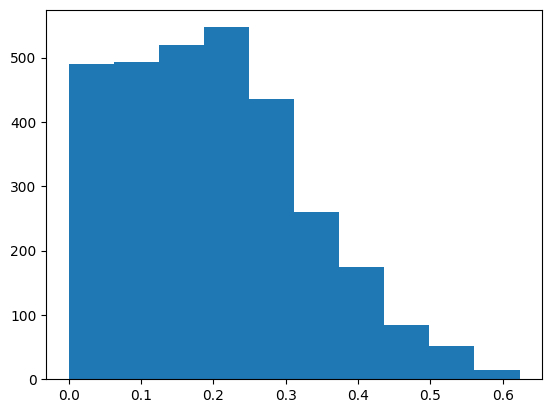

In [111]:
plt.hist(ecarts)

In [112]:
good_pred_probs_mask = ecarts>=0.14

print((good_pred_probs_mask).sum()/Y_probs.shape[0])


preds_wdl = np.argmax(Y_probs, axis=1)
preds_wdl[preds_wdl==0] = -1
preds_wdl[preds_wdl==1] = 0
preds_wdl[preds_wdl==2] = 1

print((preds_wdl[good_pred_probs_mask]==Y[good_pred_probs_mask]).sum()/good_pred_probs_mask.sum())

0.644299674267101


NameError: name 'Y' is not defined

Le modèle SVC est meilleur que la reglog (pour être définitivement sûr d'éviter les risques d'overfitting, faire un train test split avec stratify sur la league).

J'arrive à choper 53% des données avec une précision de 63% avec un seuil de proba de bonne prédicition de 0.44. La reglog me permet de choper 45% des données avec une précision de 52% au même seuil.

Par ailleurs, le critère de seuillage basé sur l'écart minimal entre les deux plus fortes probas ne donne pas significativement de meilleurs résultats que . A 0.45 de seuil minimale, SVC surperforme la reglog en train.

Par contre, le reglog est meilleure que la SVC sur les variables wdl.

In [113]:
good_pred_prob_threshold = 0.44
bad_pred_probs_mask = pred_probs<good_pred_prob_threshold

In [114]:
np.save("results/svc_on_matchs_stats_vars_bad_pred_probs_mask_0_44_threshlod.npy", bad_pred_probs_mask)

In [115]:
data_home_away_team_of_interest_bad_pred

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

In [116]:
mask_na = np.array(data_home_away_team_of_interest_bad_pred.isnull().sum(axis=1)>0)
np.save("results/mask_nan_matchs_stats_vars.npy", mask_na)

NameError: name 'data_home_away_team_of_interest_bad_pred' is not defined

#### Error Analysis 2

Players dataset

In [117]:
path_home_player = "data/Train_Data/train_home_player_statistics_df.csv"
path_away_player = "data/Train_Data/train_away_player_statistics_df.csv"

data_home_player = pd.read_csv(path_home_player)
data_away_player = pd.read_csv(path_away_player)

In [118]:
data_home_player

,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,0,Ligue 1,Toulouse,defender,Agustín Rogel,0.0,8.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Ligue 1,Toulouse,defender,Mathieu Goncalves,0.0,7.0,4.0,0.0,0.0,...,63.0,14.0,13.0,0.0,36.0,77.0,NaN,NaN,NaN,NaN
2,0,Ligue 1,Toulouse,goalkeeper,Baptiste Reynet,0.0,33.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN
3,0,Ligue 1,Toulouse,midfielder,Jean-Victor Makengo,8.0,27.0,2.0,0.0,8.0,...,63.0,0.0,13.0,6.0,17.0,0.0,NaN,NaN,NaN,NaN
4,0,Ligue 1,Toulouse,NaN,Efthymios Koulouris,2.0,23.0,27.0,14.0,8.0,...,63.0,17.0,10.0,13.0,27.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237074,12302,La Liga,Valencia,midfielder,Carlos Soler,3.0,17.0,3.0,0.0,6.0,...,0.0,28.0,18.0,12.0,6.0,77.0,NaN,NaN,NaN,NaN
237075,12302,La Liga,Valencia,attacker,Kévin Gameiro,0.0,10.0,1.0,16.0,12.0,...,77.0,34.0,27.0,19.0,24.0,0.0,NaN,NaN,NaN,NaN
237076,12302,La Liga,Valencia,midfielder,Francis Coquelin,0.0,50.0,10.0,0.0,0.0,...,0.0,28.0,71.0,6.0,27.0,77.0,NaN,NaN,NaN,NaN
237077,12302,La Liga,Valencia,goalkeeper,Jaume Doménech,0.0,9.0,0.0,0.0,0.0,...,63.0,0.0,0.0,0.0,4.0,0.0,NaN,NaN,NaN,NaN


In [119]:
count = 0
for column in data_home_player.columns:
    if '_sum' in column:
        print(column)
        count+=1

print(count)

PLAYER_ACCURATE_CROSSES_season_sum
PLAYER_ACCURATE_PASSES_season_sum
PLAYER_AERIALS_WON_season_sum
PLAYER_ASSISTS_season_sum
PLAYER_BIG_CHANCES_CREATED_season_sum
PLAYER_BIG_CHANCES_MISSED_season_sum
PLAYER_BLOCKED_SHOTS_season_sum
PLAYER_CAPTAIN_season_sum
PLAYER_CLEARANCES_season_sum
PLAYER_CLEARANCE_OFFLINE_season_sum
PLAYER_DISPOSSESSED_season_sum
PLAYER_DRIBBLED_ATTEMPTS_season_sum
PLAYER_DRIBBLED_PAST_season_sum
PLAYER_DUELS_LOST_season_sum
PLAYER_DUELS_WON_season_sum
PLAYER_ERROR_LEAD_TO_GOAL_season_sum
PLAYER_FOULS_season_sum
PLAYER_FOULS_DRAWN_season_sum
PLAYER_GOALKEEPER_GOALS_CONCEDED_season_sum
PLAYER_GOALS_season_sum
PLAYER_GOALS_CONCEDED_season_sum
PLAYER_HIT_WOODWORK_season_sum
PLAYER_INTERCEPTIONS_season_sum
PLAYER_KEY_PASSES_season_sum
PLAYER_MINUTES_PLAYED_season_sum
PLAYER_OFFSIDES_season_sum
PLAYER_OWN_GOALS_season_sum
PLAYER_PASSES_season_sum
PLAYER_PENALTIES_COMMITTED_season_sum
PLAYER_PENALTIES_MISSES_season_sum
PLAYER_PENALTIES_SAVED_season_sum
PLAYER_PENALTIES_

In [120]:
len(np.unique(data_home_player.TEAM_NAME))

350

In [121]:
data_home_player[data_home_player.ID==0]

,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,0,Ligue 1,Toulouse,defender,Agustín Rogel,0.0,8.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Ligue 1,Toulouse,defender,Mathieu Goncalves,0.0,7.0,4.0,0.0,0.0,...,63.0,14.0,13.0,0.0,36.0,77.0,NaN,NaN,NaN,NaN
2,0,Ligue 1,Toulouse,goalkeeper,Baptiste Reynet,0.0,33.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN
3,0,Ligue 1,Toulouse,midfielder,Jean-Victor Makengo,8.0,27.0,2.0,0.0,8.0,...,63.0,0.0,13.0,6.0,17.0,0.0,NaN,NaN,NaN,NaN
4,0,Ligue 1,Toulouse,NaN,Efthymios Koulouris,2.0,23.0,27.0,14.0,8.0,...,63.0,17.0,10.0,13.0,27.0,0.0,NaN,NaN,NaN,NaN
5,0,Ligue 1,Toulouse,midfielder,Ibrahim Sangaré,0.0,44.0,26.0,14.0,8.0,...,0.0,34.0,53.0,8.0,46.0,77.0,NaN,NaN,NaN,NaN
6,0,Ligue 1,Toulouse,midfielder,Mathieu Dossevi,100.0,24.0,4.0,14.0,25.0,...,63.0,48.0,37.0,54.0,38.0,0.0,NaN,NaN,NaN,NaN
7,0,Ligue 1,Toulouse,defender,Nicolas Isimat-Mirin,0.0,32.0,46.0,0.0,0.0,...,0.0,0.0,37.0,0.0,25.0,77.0,NaN,NaN,NaN,NaN
8,0,Ligue 1,Toulouse,defender,Issiaga Sylla,14.0,52.0,52.0,14.0,8.0,...,0.0,28.0,55.0,23.0,55.0,77.0,NaN,NaN,NaN,NaN
9,0,Ligue 1,Toulouse,NaN,Aaron Leya Iseka,0.0,5.0,10.0,0.0,0.0,...,63.0,0.0,0.0,6.0,49.0,0.0,NaN,NaN,NaN,NaN


In [122]:
mask = data_home_player[data_home_player.ID==0].iloc[2, :]!=0
xx = data_home_player[data_home_player.ID==0].iloc[2, :][mask]

for column, x in zip(xx.index, xx):
    print(column, x)

LEAGUE Ligue 1
TEAM_NAME Toulouse
POSITION goalkeeper
PLAYER_NAME Baptiste Reynet
PLAYER_ACCURATE_PASSES_season_sum 33.0
PLAYER_AERIALS_WON_season_sum 2.0
PLAYER_CAPTAIN_season_sum nan
PLAYER_CLEARANCES_season_sum 16.0
PLAYER_DUELS_LOST_season_sum 1.0
PLAYER_DUELS_WON_season_sum 2.0
PLAYER_GOALKEEPER_GOALS_CONCEDED_season_sum 100.0
PLAYER_GOALS_CONCEDED_season_sum 100.0
PLAYER_KEY_PASSES_season_sum 2.0
PLAYER_MINUTES_PLAYED_season_sum 100.0
PLAYER_PASSES_season_sum 48.0
PLAYER_PENALTIES_SAVED_season_sum 100.0
PLAYER_SAVES_season_sum 78.0
PLAYER_SAVES_INSIDE_BOX_season_sum 84.0
PLAYER_STARTING_LINEUP_season_sum 100.0
PLAYER_TACKLES_season_sum 1.0
PLAYER_TOTAL_DUELS_season_sum 2.0
PLAYER_YELLOWCARDS_season_sum 20.0
PLAYER_PUNCHES_season_sum nan
PLAYER_LONG_BALLS_season_sum nan
PLAYER_LONG_BALLS_WON_season_sum nan
PLAYER_SHOTS_OFF_TARGET_season_sum nan
PLAYER_ACCURATE_PASSES_season_average 27.0
PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average 53.0
PLAYER_AERIALS_WON_season_average 2.0
PLA

PLAYER_ACCURATE_CROSSES_season_sum
PLAYER_TOTAL_CROSSES_season_sum
PLAYER_LONG_BALLS_WON_season_sum
PLAYER_AERIALS_WON_season_sum

PLAYER_ACCURATE_PASSES_season_sum
PLAYER_KEY_PASSES_season_sum
PLAYER_PASSES_season_sum
PLAYER_ASSISTS_season_sum
PLAYER_GOALS_season_sum
PLAYER_HIT_WOODWORK_season_sum
PLAYER_PENALTIES_MISSES_season_sum
PLAYER_PENALTIES_SCORED_season_sum


PLAYER_BIG_CHANCES_CREATED_season_sum
PLAYER_BIG_CHANCES_MISSED_season_sum


PLAYER_DISPOSSESSED_season_sum
PLAYER_DUELS_LOST_season_sum
PLAYER_DUELS_WON_season_sum
PLAYER_ERROR_LEAD_TO_GOAL_season_sum

PLAYER_GOALKEEPER_GOALS_CONCEDED_season_sum
PLAYER_PENALTIES_SAVED_season_sum
PLAYER_SAVES_season_sum
PLAYER_SAVES_INSIDE_BOX_season_sum
PLAYER_CLEARANCES_season_sum
PLAYER_CLEARANCE_OFFLINE_season_sum

PLAYER_MINUTES_PLAYED_season_sum
PLAYER_STARTING_LINEUP_season_sum

PLAYER_SHOTS_BLOCKED_season_sum
PLAYER_SHOTS_ON_TARGET_season_sum
PLAYER_SHOTS_TOTAL_season_sum

PLAYER_SUCCESSFUL_DRIBBLES_season_sum
